# **1132_MIS581社群媒體分析_期末專案**
- 指導教授：黃三益
- 　　組員：郭展州N124020012、傅才容N124320030、莊筑雅N124320004、李明容N124320016


# **專案名稱：多層次特徵融合之假新聞偵測與主題分析系統**
## **專案目標**
1. 精準判斷新聞或推文之真偽
2. 剖析假新聞常見主題與關鍵字
3. 結合多模型協作(傳統 ML × BERT/SBERT × LLM)，驗證不同特徵組合與分類器效果，建立可擴充的偵測流程
## **專案流程**
1. 資料蒐集與前處理
2. 各項特徵提取：NER特徵、情緒特徵、綜合特徵工程及分類模型評估
3. 主題模型BERTopic
4. LLM 多模型裁決
5. 最終整合評估
## **資料來源**
1. fake-and-real-news-dataset (ISOT Fake News detection dataset) https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
2. Twitter Dataset (Referenced from CIC Truth Seeker Dataset 2023) https://www.kaggle.com/datasets/sudishbasnet/truthseekertwitterdataset2023/data?select=Truth_Seeker_Model_Dataset.csv

# **專案執行**

## 一、套件安裝與引入

In [46]:
# 🔧 安裝核心資料處理與模型套件
!pip install pandas numpy scikit-learn matplotlib seaborn tqdm nltk vaderSentiment empath tabulate
# 🔎 安裝 BERT 相關（transformers, pipeline）
!pip install transformers
# 🤖 安裝命名實體辨識用預訓練模型
!pip install torch
# 🧠 安裝情緒分析微調模型
!pip install sentence-transformers
# 📊 安裝主題建模：BERTopic + HDBSCAN（支援 clustering）
!pip install bertopic hdbscan
# 🗂 字體設定用（如你加載了自訂字體）
!pip install fonttools
!pip install --upgrade nltk

In [47]:
# from google.colab import drive
# drive.mount('/content/drive')

In [48]:
# GPU 加速

import torch

# GPU 加速
print("=== PyTorch GPU 加速環境檢查 ===")
print(f"PyTorch 版本: {torch.__version__}")
print(f"PyTorch 編譯的 CUDA 版本: {torch.version.cuda}")
print(f"是否支援 CUDA: {torch.cuda.is_available()}")

try:
    if torch.cuda.is_available():
        gpu_count = torch.cuda.device_count()
        current_gpu = torch.cuda.current_device()
        device_name = torch.cuda.get_device_name(current_gpu)

        print(f"偵測到 {gpu_count} 個 GPU")
        print(f"當前使用的 GPU：{device_name}")
        device = torch.device("cuda")
    else:
        raise RuntimeError("CUDA 不可用，將使用 CPU")
except Exception as e:
    print(f"無法使用 GPU：{e}")
    device = torch.device("cpu")

print(f"pytorch可用的GPU為：{device}")


=== PyTorch GPU 加速環境檢查 ===
PyTorch 版本: 2.5.1+cu121
PyTorch 編譯的 CUDA 版本: 12.1
是否支援 CUDA: True
偵測到 1 個 GPU
當前使用的 GPU：NVIDIA GeForce RTX 4050 Laptop GPU
pytorch可用的GPU為：cuda


In [49]:
# === NLP / 資料處理基礎 ===
import os, re, ssl, json, concurrent.futures, warnings, itertools
import numpy as np
import pandas as pd
from tqdm import tqdm

# NLTK ───────────────────────────────────────────────────────────
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.data.path.extend([
    '/usr/nltk_data', '/usr/local/nltk_data', '/usr/share/nltk_data',
    '/usr/local/share/nltk_data', '/root/nltk_data'
])

# === Scikit-learn 基礎工具 ===
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate)
from sklearn.feature_extraction.text import (
    TfidfVectorizer, CountVectorizer)
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, f1_score,
    accuracy_score, precision_score, recall_score, make_scorer)
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 傳統分類器
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# === 進階 NLP / 向量化 ===
from sentence_transformers import SentenceTransformer          # SBERT
from transformers import (
    pipeline, AutoTokenizer, AutoModelForTokenClassification)

# === 主題模型 / 聚類 ===
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN

# === 視覺化 ===
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import fontManager
fontManager.addfont('./public/TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = 14

# === VADER & Empath (情緒 / 詞典) ===
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
try:
    from empath import Empath
    empath_available = True
    empath_lexicon = Empath()
except ModuleNotFoundError:
    empath_available = False
    warnings.warn("Empath 尚未安裝，將略過相關特徵。")

# === 其他輔助 ===
from tabulate import tabulate
warnings.filterwarnings('ignore')  # 避免雜訊訊息

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TUF\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TUF\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\TUF\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\TUF\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 匯入fake-and-real-news-dataset真假新聞資料集

In [50]:
# 載入fake-and-real-news-dataset資料集
fake_df = pd.read_csv('./raw_data/fake.csv')            
true_df = pd.read_csv('./raw_data/true.csv')            

# 合併 title 和 text 成新的 text 欄位
fake_df['text'] = fake_df['title'].astype(str) + " " + fake_df['text'].astype(str)
true_df['text'] = true_df['title'].astype(str) + " " + true_df['text'].astype(str)

# 加上 label 欄位
fake_df['label'] = 1
true_df['label'] = 0

# 取前 1000 筆
# dataNum = 50
# news_data = pd.concat([fake_df.iloc[:dataNum], true_df.iloc[:dataNum]], ignore_index=True)
news_data = fake_df

# 移除空值並只保留 text 和 label 欄位
news_data = news_data[news_data['text'].notna()].reset_index(drop=True)
news_data = news_data[['text', 'label']]

# 檢查各類別數量
print(news_data['label'].value_counts())
print(news_data.head(1))

label
1    23481
Name: count, dtype: int64
                                                text  label
0   Donald Trump Sends Out Embarrassing New Year’...      1


### 匯入Twitter Dataset推特真假推文資料集

In [51]:
# 推特資料處理(為了嘗試解決 加入TF-IDF過擬合&embed過強 可能是因為文本特徵太明顯的問題)
tweet_df = pd.read_csv('./raw_data/Truth_Seeker_Model_Dataset_unindex.csv', encoding='ISO-8859-1')            
tweet_data = tweet_df[['BinaryNumTarget', 'tweet', '5_label_majority_answer']].copy()

# 清理
tweet_data = tweet_data.dropna()
tweet_data = tweet_data[~tweet_data['tweet'].str.contains('#REF!', na=False)]
valid_labels = ['Agree', 'Mostly Agree']
tweet_data = tweet_data[tweet_data['5_label_majority_answer'].isin(valid_labels)]

# 移除 5_label_majority_answer 欄位，並重新命名欄位
tweet_data = tweet_data.rename(columns={'BinaryNumTarget': 'label', 'tweet': 'text'})
tweet_data = tweet_data[['text', 'label']]

# tweet_data_num = 50  # 取n筆
# tweet_data = tweet_data.groupby('label').apply(
#     lambda x: x.sample(n=min(len(x), tweet_data_num), random_state=42)
# ).reset_index(drop=True)

print(tweet_data['label'].value_counts())
print(tweet_data.head(10))

label
1    55692
0    52449
Name: count, dtype: int64
                                                 text  label
0   @POTUS Biden Blunders - 6 Month Update\n\nInfl...      1
2   THE SUPREME COURT is siding with super rich pr...      1
3   @POTUS Biden Blunders\n\nBroken campaign promi...      1
4   @OhComfy I agree. The confluence of events rig...      1
5   I've said this before, but it really is incred...      1
6   As many face backlogged rent payments, America...      1
7   @Thomas1774Paine @JoeBiden\n#DOJ@TheJusticeDep...      1
8   @SocialismIsDone @TheeKHiveQueenB Its a win fo...      1
10  BREAKING NEWS: Mitch McConnell accuses Preside...      1
11  @aplemkseriously @CoriBush @CoriBush knew July...      1


In [52]:
# 合併兩份不同來源資料集
data = pd.concat([news_data, tweet_data], ignore_index=True)

**需要做文本預處理嗎?**

目的:
- 建立分類器來預測真假新聞 -> (TF-IDF + 分類模型需要乾淨的資料，有幫助)
- 分析NER 結果與語意分佈 -> (會破壞語意)
- 建立主題模型來探索語意主題（BERTopic -> (會破壞語意)

In [53]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
punct_pattern = re.compile(r"[^a-z ]")

def preprocess(text):
    text = text.lower()
    text = punct_pattern.sub(" ", text)
    # 用 preserve_line=True 避開 punkt_tab
    tokens = word_tokenize(text, preserve_line=True)
    tokens = [
        lemmatizer.lemmatize(w)
        for w in tokens
        if w not in stop_words and len(w) > 1
    ]
    return tokens

data['tokens'] = data['text'].astype(str).apply(preprocess)
data['clean_text'] = data['tokens'].apply(lambda x: ' '.join(x))

## 二、各項特徵處理與分類器評估表現
### NER特徵處理

In [54]:
from sklearn.cluster import KMeans
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm

# 載入模型與 tokenizer
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=0)

# 建立 NER 結果列表
ner_rows = []

# 分切字串
def split_text(text, chunk_size=512):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# 針對每篇文章跑 NER（可用 tqdm 顯示進度條）
for idx, text in tqdm(data['text'].astype(str).items()):
    try:
        chunks = split_text(text)
        all_ents = []
        for chunk in chunks:
            all_ents.extend(ner_pipeline(chunk))  # 對每段跑 NER
        for ent in all_ents:
            ner_rows.append({
                "index": idx,
                "entity": ent['entity_group'],  # e.g., PER, LOC
                "word": ent['word'],
                "score": ent['score']
            })
    except Exception as e:
        print(f"Error at idx {idx}: {e}")

# 建立 DataFrame
ner_df = pd.DataFrame(ner_rows)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
131622it [52:15, 41.98it/s]


In [55]:
ner_df.head(10)

,index,entity,word,score
0,0,PER,Donald Trump,0.998793
1,0,PER,Donald Trump,0.998276
2,0,MISC,Americans,0.998982
3,0,ORG,Fake News Media,0.919783
4,0,PER,Angry Pants,0.970617
5,0,LOC,America,0.999643
6,0,LOC,Country,0.439498
7,0,ORG,F,0.988801
8,0,ORG,##ake News Media,0.961965
9,0,LOC,America,0.999575


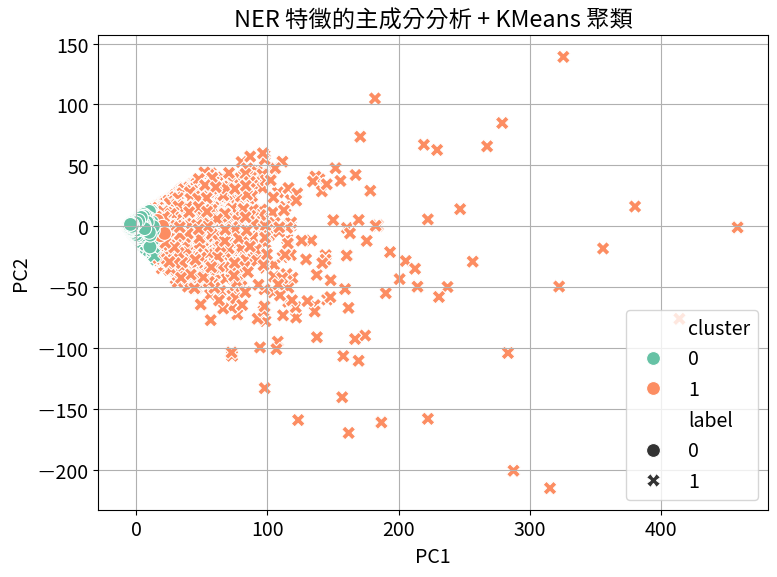

In [56]:
# 整合 label
merged_df = ner_df.merge(data[['label']], left_on='index', right_index=True)

# 聚合所有 entity 類型的出現次數
entity_counts_all = (
    merged_df.groupby(['index', 'entity'])
    .size()
    .unstack(fill_value=0)  # 得到每篇文章各類實體數
    .reset_index()
)

# 合併 label
entity_counts_all = entity_counts_all.merge(data[['label']], left_on='index', right_index=True)

# 建模欄位選擇：所有實體類別欄位（排除 index, label）
feature_cols = [col for col in entity_counts_all.columns if col not in ['index', 'label']]
kmeans_fit_pred_data = entity_counts_all[feature_cols]

# 做 KMeans 聚類
from sklearn.cluster import KMeans
import seaborn as sns

kmeans = KMeans(n_clusters=2, random_state=42)
entity_counts_all['cluster'] = kmeans.fit_predict(kmeans_fit_pred_data)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(kmeans_fit_pred_data)
entity_counts_all['PC1'] = X_pca[:, 0]
entity_counts_all['PC2'] = X_pca[:, 1]
# 視覺化聚類結果
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=entity_counts_all,
    x='PC1', y='PC2', hue='cluster', style='label',
    palette='Set2', s=100
)

plt.title('NER 特徵的主成分分析 + KMeans 聚類')
plt.grid(True)
plt.tight_layout()
plt.show()

1. 使用NER特徵進行KMeans聚類，無監督學習自動分成兩群，上圖為模型前的探索性資料分析(EDA)結果，觀察結果:KMeans聚類有部分成功聚出假新聞群，橘色cluster1幾乎都是叉叉為假新聞群，綠色cluster0包含較多真新聞與部分假新聞。
2. 結論：分群重疊明顯，整體分群效果不算非常好，但初步判斷NER有區別能力，需結合更多特徵進行多模態聚類模型評估!

### 多模態特徵+分類器評估

#### A. 使用「命名實體識別(NER)」來辨識真假新聞
使用NER當作特徵，提取出的`人名`、`組織`、`地名數量`作為詞彙特徵，加上`4個分類器(LogisticRegression、DecisionTree、SVM、RandomForest)`評估結果來分類真假新聞，預測這篇新聞是真/假。

In [57]:
from sklearn import svm

# ── Part 1：NER特徵模型比較 ───────────────────────────
# === 建立特徵（NER 例子） ===
entity_counts = ner_df.groupby(['index', 'entity']).size().unstack(fill_value=0)
data_with_ner = data.copy()
data_with_ner = data_with_ner.join(entity_counts, how='left').fillna(0)

X = data_with_ner[['PER', 'ORG', 'LOC']]
y = data_with_ner['label']

# === 分類器列表 ===
classifiers = {
    "LogReg": LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(),
    "SVM": svm.SVC(probability=True),
    "RandomForest": RandomForestClassifier(random_state=42)
}

# === K-fold 設定 ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 儲存平均 f1-score 結果
results = []

# === 執行交叉驗證並印出每個模型報告 ===
for name, model in classifiers.items():
    print(f"\n=== {name} 分類結果（5-fold） ===")
    y_true_all, y_pred_all = [], []
    fold_f1_scores = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        clf = clone(model)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

        fold_f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

    avg_f1 = np.mean(fold_f1_scores)
    print(classification_report(
        y_true_all, y_pred_all,
        target_names=["真新聞", "假新聞"],
        digits=2
    ))

    results.append({
        "classifier": name,
        "f1_weighted": avg_f1
    })

# === 比較結果表格 ===
result_df = pd.DataFrame(results).sort_values(by="f1_weighted", ascending=False).reset_index(drop=True)
print("🏁 各模型比較：")
print(tabulate(result_df, headers="keys", tablefmt="fancy_grid"))

# === 找出最佳模型 ===
best = result_df.iloc[0]
print(f"\n🏆 最佳分類器為：{best['classifier']}，weighted F1 = {best['f1_weighted']:.4f}")



=== LogReg 分類結果（5-fold） ===
              precision    recall  f1-score   support

         真新聞       0.46      0.30      0.36     52449
         假新聞       0.62      0.77      0.69     79173

    accuracy                           0.58    131622
   macro avg       0.54      0.53      0.53    131622
weighted avg       0.56      0.58      0.56    131622


=== DecisionTree 分類結果（5-fold） ===
              precision    recall  f1-score   support

         真新聞       0.56      0.36      0.44     52449
         假新聞       0.66      0.81      0.73     79173

    accuracy                           0.63    131622
   macro avg       0.61      0.59      0.58    131622
weighted avg       0.62      0.63      0.61    131622


=== SVM 分類結果（5-fold） ===
              precision    recall  f1-score   support

         真新聞       0.58      0.29      0.39     52449
         假新聞       0.65      0.86      0.74     79173

    accuracy                           0.63    131622
   macro avg       0.61      0.58     

+ NER提取特徵預測結果尚可，NER特徵對真假新聞辨識有一定程度作用，`最佳分類器：RandomForest`，`Weighted F1 = `。
+ 結論：特徵太少，只有三維「人名/地名/組織」，資訊量太低。很多新聞或推文不一定包含這三類實體，造成大量為 0。

#### B. 使用「情緒分析」來辨識真假新聞

利用`多個情緒特徵模型進行`，加上`4個分類器(LogisticRegression、DecisionTree、SVM、RandomForest)`比較，評估最佳結果來分類真假新聞，預測這篇新聞是真/假。
+ **情緒模型介紹：**
1. distilbert：一款基於SST-2微調的輕量級BERT模型，常用於英文產品評論或客服對話中的情緒正負分類任務。
2. roberta-twitter：專為Twitter資料訓練的RoBERTa模型，廣泛應用於社群貼文的輿情分析與社會事件情緒偵測。
3. bertweet：以海量推文語料訓練的BERT模型，特別適用於社群媒體上的即時情緒追蹤與用戶反應分析。
4. nlptown：一個支援多語言、可輸出1～5星等級的情緒強度模型，常用於多語評論評等、顧客滿意度分析等任務。

In [ ]:
from tqdm import tqdm

# ── Part 2：情緒特徵模型比較 ───────────────────────────
sentiment_models = {
    "distilbert"      : "distilbert-base-uncased-finetuned-sst-2-english",
    "roberta-twitter" : "cardiffnlp/twitter-roberta-base-sentiment",
    "bertweet"        : "finiteautomata/bertweet-base-sentiment-analysis",
    "nlptown"         : "nlptown/bert-base-multilingual-uncased-sentiment"
}

classifiers = {
    "LogReg"       : LogisticRegression(max_iter=1000),
    "DecisionTree" : DecisionTreeClassifier(),
    "LinearSVC"    : LinearSVC(),
    "RandomForest" : RandomForestClassifier(random_state=42)
}

def split_chunks(txt, size=512):
    return [txt[i:i+size] for i in range(0, len(txt), size)]

def senti_score(txt, pipe):
    try:
        res = pipe(split_chunks(txt))
        pos = [r['score'] for r in res if 'POS' in r['label'].upper()]
        neg = [r['score'] for r in res if 'NEG' in r['label'].upper()]
        return (sum(pos)/len(pos)) if pos and sum(pos) > sum(neg) \
               else -(sum(neg)/len(neg)) if neg else 0.0
    except Exception:
        return 0.0
    
# 批次處理 + 情緒得分
def senti_score_batch(texts, pipe, chunk_size=512, batch_size=32):
    all_scores = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Sentiment Batch Inference"):
        batch = texts[i:i+batch_size]
        batch_scores = []
        for text in batch:
            try:
                chunks = split_chunks(text, chunk_size)
                res = [pipe(chunk)[0] for chunk in chunks]  # 每段各自送出
                pos = [r['score'] for r in res if 'POS' in r['label'].upper()]
                neg = [r['score'] for r in res if 'NEG' in r['label'].upper()]
                score = (sum(pos)/len(pos)) if pos and sum(pos) > sum(neg) \
                        else -(sum(neg)/len(neg)) if neg else 0.0
            except:
                score = 0.0
            batch_scores.append(score)
        all_scores.extend(batch_scores)
    return all_scores

all_results, model_mean = [], []

for m_key, m_name in sentiment_models.items():
    print(f"\n🔍 Sentiment Model: {m_key}")
    pipe = pipeline("sentiment-analysis", model=m_name, truncation=True, device=0)
    data_tmp = data.copy()
    # tqdm.pandas()
    # data_tmp['sentiment_score'] = data_tmp['text'].astype(str).progress_apply(
    #     lambda t: senti_score(t, pipe)
    # )
    texts = data_tmp['text'].astype(str).tolist()
    data_tmp['sentiment_score'] = senti_score_batch(texts, pipe)

    X_senti = data_tmp[['sentiment_score']]
    y       = data_tmp['label']

    f1_collect = []
    for clf_key, clf in classifiers.items():
        X_tr, X_te, y_tr, y_te = train_test_split(X_senti, y, test_size=0.2, random_state=42)
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_te)
        f1_val = f1_score(y_te, y_pred, average='weighted')
        f1_collect.append(f1_val)
        all_results.append({"model": m_key, "classifier": clf_key, "f1": f1_val})

    model_mean.append({"model": m_key, "mean_f1": np.mean(f1_collect)})

# ➜ 找平均 F1 最高的情緒模型
model_df = pd.DataFrame(model_mean).sort_values('mean_f1', ascending=False)
best_senti = model_df.iloc[0]['model']
print("\n📊  情緒模型平均 F1：")
print(tabulate(model_df, headers="keys", tablefmt="fancy_grid"))
print(f"\n🏆 最佳情緒模型：{best_senti}")



🔍 Sentiment Model: distilbert


Device set to use cuda:0
Sentiment Batch Inference:  21%|██        | 863/4114 [12:56<08:23,  6.46it/s]  

+ 結論： 情緒預測真假新聞表現不好，整體分類效果偏弱，`最佳情緒模型：RandomForest`，`最佳分類器：RandomForest`，`Weighted F1 = `。

#### C. 使用「NER+情緒」來辨識真假新聞
延續步驟B選出最佳情緒模型`___`後，加上`4個分類器(LogisticRegression、DecisionTree、SVM、RandomForest)`比較。

In [ ]:
# ── Part 3：NER + Best Sentiment 特徵訓練 ──────────────
# 1️⃣ 用最佳情緒模型重新計算 sentiment_score
best_pipe = pipeline("sentiment-analysis", model=sentiment_models[best_senti], truncation=True, device=0)
tqdm.pandas()
data['sentiment_score'] = data['text'].astype(str).progress_apply(lambda t: senti_score(t, best_pipe))

# 2️⃣ 合併 NER (PER/ORG/LOC) + sentiment_score
feature_df = data_with_ner[['PER', 'ORG', 'LOC']].join(data['sentiment_score'])
X_full = feature_df
y_full = data['label']

# 3️⃣ 四個分類器
final_clfs = {
    "LogReg"       : LogisticRegression(max_iter=1000),
    "DecisionTree" : DecisionTreeClassifier(),
    "SVM"          : svm.SVC(probability=True),
    "RandomForest" : RandomForestClassifier(random_state=42)
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_res = []

for clf_key, base_clf in final_clfs.items():
    y_all_t, y_all_p, f1_list = [], [], []

    for tr_idx, te_idx in kf.split(X_full, y_full):
        X_tr, X_te = X_full.iloc[tr_idx], X_full.iloc[te_idx]
        y_tr, y_te = y_full.iloc[tr_idx], y_full.iloc[te_idx]

        clf = clone(base_clf)
        clf.fit(X_tr, y_tr)
        y_pr = clf.predict(X_te)

        y_all_t.extend(y_te); y_all_p.extend(y_pr)
        f1_list.append(f1_score(y_te, y_pr, average='weighted'))

    print(f"\n=== {clf_key} 整體報告 ===")
    print(classification_report(y_all_t, y_all_p, target_names=["真新聞","假新聞"], digits=2))

    final_res.append({"classifier": clf_key, "f1_weighted": np.mean(f1_list)})

# 4️⃣ 比較表 & 最佳分類器
final_df = pd.DataFrame(final_res).sort_values('f1_weighted', ascending=False).reset_index(drop=True)
print("\n📊  最終 4 分類器比較：")
print(tabulate(final_df, headers="keys", tablefmt="fancy_grid"))

best_cls = final_df.iloc[0]
print(f"\n🏆 最終最佳組合：情緒模型={best_senti} + 分類器={best_cls['classifier']}，weighted F1={best_cls['f1_weighted']:.4f}")

# 5️⃣ (可選) 視覺化
plt.figure(figsize=(8,5))
sns.barplot(x='classifier', y='f1_weighted', data=final_df, palette='Set2')
plt.title(f'NER + Sentiment({best_senti})  4 分類器比較')
plt.ylabel('Weighted F1')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


+ 結論：可在進行優化，`最佳分類器：RandomForest`，`Weighted F1 = `。

#### D. 使用「NER+情緒+TFIDF」來辨識真假新聞
延續步驟C.加入`TFIDF`，，加上`4個分類器(LogisticRegression、DecisionTree、SVM、RandomForest)`比較。

In [ ]:
# ── Part 4：TF-IDF + NER + Best Sentiment 模型 ──────────────────────
# ✅ 使用 Part 2 最佳情緒模型重新生成 sentiment_score
senti_model_name = sentiment_models[best_senti]
sentiment_pipe = pipeline("sentiment-analysis", model=senti_model_name, truncation=True, device=0)
tqdm.pandas()
data['sentiment_score'] = data['text'].astype(str).progress_apply(lambda t: senti_score(t, sentiment_pipe))

# 1️⃣ 建立 TF-IDF 特徵
tfidf_vec = TfidfVectorizer(max_features=200, ngram_range=(1, 2))
tfidf_mat = tfidf_vec.fit_transform(data['clean_text'].fillna(''))
tfidf_df = pd.DataFrame(tfidf_mat.toarray(),
                        columns=tfidf_vec.get_feature_names_out(),
                        index=data.index)

# 2️⃣ 取得 NER 特徵 + 最新 sentiment 分數
ner_df     = data_with_ner[['PER', 'ORG', 'LOC']].copy()
senti_df   = data[['sentiment_score']]
X_features = pd.concat([ner_df, senti_df, tfidf_df], axis=1)
y_target   = data['label']

# 3️⃣ 定義分類器
classifiers = {
    "LogReg"       : LogisticRegression(max_iter=1000),
    "DecisionTree" : DecisionTreeClassifier(),
    "SVM"          : svm.SVC(probability=True),
    "RandomForest" : RandomForestClassifier(random_state=42)
}

# 4️⃣ Cross-Validation 訓練
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for clf_name, clf_model in classifiers.items():
    print(f"\n=== {clf_name} 分類結果（5-fold） ===")
    y_all_true, y_all_pred, f1s = [], [], []

    for train_idx, test_idx in kf.split(X_features, y_target):
        X_train, X_test = X_features.iloc[train_idx], X_features.iloc[test_idx]
        y_train, y_test = y_target.iloc[train_idx], y_target.iloc[test_idx]

        clf = clone(clf_model)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        y_all_true.extend(y_test)
        y_all_pred.extend(y_pred)
        f1s.append(f1_score(y_test, y_pred, average='weighted'))

    print(classification_report(y_all_true, y_all_pred,
                                target_names=["真新聞", "假新聞"], digits=2))

    results.append({
        "classifier": clf_name,
        "f1_weighted": np.mean(f1s)
    })

# 5️⃣ 輸出總結
result_df = pd.DataFrame(results).sort_values(by='f1_weighted', ascending=False).reset_index(drop=True)

print("\n📊 TF-IDF + NER + Sentiment 分類器比較：")
print(tabulate(result_df, headers="keys", tablefmt="fancy_grid"))

best = result_df.iloc[0]
print(f"\n🏆 最佳分類器為：{best['classifier']}，weighted F1 = {best['f1_weighted']:.4f}")

# ➕ 可選視覺化
plt.figure(figsize=(8,5))
sns.barplot(x='classifier', y='f1_weighted', data=result_df, palette='Set3')
plt.title(f"TF-IDF + NER + Sentiment({best_senti}) 分類器比較")
plt.ylabel('Weighted F1')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 依 label 分群
true_texts = data[data['label'] == 0]['clean_text'].fillna('')
fake_texts = data[data['label'] == 1]['clean_text'].fillna('')

# 建立 TF-IDF 向量器（可使用相同設定以便比較）
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))

# 擬合於真新聞
true_tfidf_matrix = tfidf.fit_transform(true_texts)
true_feature_names = tfidf.get_feature_names_out()
true_scores = true_tfidf_matrix.mean(axis=0).A1
true_top30 = sorted(zip(true_feature_names, true_scores), key=lambda x: x[1], reverse=True)[:30]

# 擬合於假新聞（需重新建一個 vectorizer 才不會共用字典）
tfidf_fake = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
fake_tfidf_matrix = tfidf_fake.fit_transform(fake_texts)
fake_feature_names = tfidf_fake.get_feature_names_out()
fake_scores = fake_tfidf_matrix.mean(axis=0).A1
fake_top30 = sorted(zip(fake_feature_names, fake_scores), key=lambda x: x[1], reverse=True)[:30]

# 將兩個 DataFrame 加上 index 並 reset
true_df = pd.DataFrame(true_top30, columns=["真新聞詞", "真_TF-IDF"]).reset_index(drop=True)
fake_df = pd.DataFrame(fake_top30, columns=["假新聞詞", "假_TF-IDF"]).reset_index(drop=True)

# 合併為一個表格（左右比對）
compare_df = pd.concat([true_df, fake_df], axis=1)

# 顯示結果
from IPython.display import display
print("📊 真新聞 vs 假新聞 前 30 常見關鍵詞（TF-IDF 分數）")
display(compare_df)

+ 利用TFIDF找出真假新聞常見關鍵字。
+ 結論：加入TFIDF後，分類器效果提升，`最佳分類器：RandomForest`，`Weighted F1 = `。

#### E. 使用「NER+情緒+TFIDF」加入其他VADER&文字Style來辨識真假新聞
延續步驟D.加入`VADER(+Empath)與文字表達Style特徵`，，加上`4個分類器(LogisticRegression、DecisionTree、SVM、RandomForest)`比較。

In [ ]:
# ── Part 5：TF-IDF+NER+Sentiment特徵上，再加入VADER(+Empath)與文字表達Style特徵 ──────────────────────
# ------------------------------------------------------------------
# 1. 透過卡方檢定 (chi-square) 找出「假新聞 > 真新聞」最具區辨力的 n-gram
# ------------------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
import numpy as np, pandas as pd, re
from tqdm import tqdm

# （1）建一個詞袋模型（unigram+bigram，過濾英文停用字, min_df=5 避免太稀有）
cv = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=5)
X_bow = cv.fit_transform(data['clean_text'])
feature_names = np.array(cv.get_feature_names_out())

# （2）做卡方檢定；label=1 代表假新聞
chi_scores, _ = chi2(X_bow, data['label'])

# （3）只保留在假新聞出現次數 > 真新聞的詞，再取前 30 名
fake_mask = (X_bow[data['label'].values==1].sum(axis=0) >
             X_bow[data['label'].values==0].sum(axis=0)).A1
candidate_words = feature_names[fake_mask]
candidate_scores= chi_scores[fake_mask]

top_k = 30
top_idx = np.argsort(candidate_scores)[::-1][:top_k]
auto_clickbait = set(candidate_words[top_idx])

print(f"🔍 自動偵測到 {len(auto_clickbait)} 個假新聞高相關詞（前 {top_k}）：")
print(sorted(auto_clickbait))

# ------------------------------------------------------------------
# 2. 建立 VADER / Empath / Style 特徵（含「動態 click-bait」）
# ------------------------------------------------------------------
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
try:
    from empath import Empath
    lexicon = Empath(); use_empath = True
except ModuleNotFoundError:
    use_empath = False

tqdm.pandas()

# 2-1 VADER
vader = SentimentIntensityAnalyzer()
vader_df = (data['text'].progress_apply(vader.polarity_scores)
                       .apply(pd.Series).add_prefix('vader_'))
print("\n🧠 VADER 情緒推動特徵（前幾筆）：")
print(vader_df.head())

# 2-2 Empath（選擇幾個常用情緒社會面向）
if use_empath:
    empath_raw = data['text'].progress_apply(lambda t: lexicon.analyze(t, normalize=True))
    empath_keep = ['positive_emotion','negative_emotion','anger','sadness',
                   'fear','politics','money','fun','love']
    empath_df = (pd.DataFrame(empath_raw.tolist())
                   [empath_keep].add_prefix('empath_'))

    print("\n🎯 NRC-Empath 情緒向量（前幾筆）：")
    print(empath_df.head())
else:
    empath_df = pd.DataFrame(index=data.index)   # 空 DF
    print("\n⚠️ 未啟用 Empath（需 pip install empath）")

# 2-3 Style features（大寫比例 / ! 密度 / 自動 click-bait 命中率）
def style_feats(txt:str):
    L = max(len(txt),1)
    txt_low = txt.lower()
    hit_cnt = sum(1 for w in auto_clickbait if w in txt_low)
    return pd.Series({
        'caps_ratio'      : sum(c.isupper() for c in txt)/L,
        'excl_ratio'      : txt.count('!')/L,
        'clickbait_ratio' : hit_cnt / len(auto_clickbait)
    })

style_df = data['text'].progress_apply(style_feats)

print("\n📝 文字表達方式特徵（大寫比例 / 感嘆號密度 / Click-bait 命中率）")
print(style_df.describe())

print("\n📊 假新聞與真新聞的 Style 特徵平均比較：")
print(pd.concat([style_df, data['label']], axis=1)
        .groupby('label').mean()
        .rename(index={0: "真新聞", 1: "假新聞"}))

# ------------------------------------------------------------------
# 3. 把新特徵接到既有 X_features（TF-IDF + NER + Best-Sentiment）
# ------------------------------------------------------------------
X_final = pd.concat([X_features, vader_df, empath_df, style_df], axis=1)
y_final = data['label']
print("🔢 新增後特徵維度 :", X_final.shape)

# ------------------------------------------------------------------
# 4. 四個分類器 × 5-fold 交叉驗證
# ------------------------------------------------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from tabulate import tabulate
import seaborn as sns, matplotlib.pyplot as plt

clfs = {
    "LogReg"      : LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(),
    "SVM"         : SVC(probability=True),
    "RandomForest": RandomForestClassifier(random_state=42)
}

kf = StratifiedKFold(5, shuffle=True, random_state=42)
rows = []

for name, base in clfs.items():
    y_t, y_p, f1s = [], [], []
    for tr, te in kf.split(X_final, y_final):
        mdl = clone(base).fit(X_final.iloc[tr], y_final.iloc[tr])
        pred = mdl.predict(X_final.iloc[te])
        y_t.extend(y_final.iloc[te]); y_p.extend(pred)
        f1s.append(f1_score(y_final.iloc[te], pred, average='weighted'))
    print(f"\n=== {name} 報告 (加 VADER / Style) ===")
    print(classification_report(y_t, y_p, target_names=['真新聞','假新聞'], digits=2))
    rows.append({"classifier": name, "f1_weighted": np.mean(f1s)})

res_df = pd.DataFrame(rows).sort_values('f1_weighted', ascending=False)
print("\n📊  加 VADER / Style / 動態 Click-bait 後分類器比較")
print(tabulate(res_df, headers="keys", tablefmt="fancy_grid"))

best_cls = res_df.iloc[0]
print(f"\n🏆  新最佳模型：{best_cls['classifier']}  (Weighted F1 = {best_cls['f1_weighted']:.4f})")

# （可選）長條圖
plt.figure(figsize=(8,4))
sns.barplot(x='classifier', y='f1_weighted', data=res_df, palette='Set2')
plt.title('加入 VADER / Style 特徵後的分類器比較')
plt.ylabel('Weighted F1')
plt.ylim(0,1); plt.tight_layout(); plt.show()


+ 結論：表現成果沒有步驟D使用「NER+情緒+TFIDF」的好，但是可以多觀察到`VADER情緒推動特徵`及`文字表達方式特徵`結果，`最佳分類器：RandomForest`，`Weighted F1 = `。

#### F. 使用「NER+情緒+SBERT」來辨識真假新聞
+ 步驟E表現不佳，改利用SBERT向量化方式與步驟D的TFIDF比較，，再加上`4個分類器(LogisticRegression、DecisionTree、SVM、RandomForest)`評估最佳結果。
+ 經前測結果，採用此模型`sentence-transformers/paraphrase-MiniLM-L6-v2`進行。
1. 使用all-MiniLM-L6-v2，最佳分類器為：RandomForest，Weighted F1 = 0.7197
2. 使用sentence-transformers/paraphrase-MiniLM-L6-v2，最佳分類器為：LogReg，Weighted F1 = 0.7467

In [ ]:
# ────── Part 6：NER+Sentiment特徵+SBERT向量化 ──────────────────────
# ▍1. SBERT 向量化
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler

model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')  # 可改其他如 'paraphrase-MiniLM-L6-v2'
sbert_embeddings = model.encode(data['clean_text'].fillna(''), show_progress_bar=True)

sbert_df = pd.DataFrame(sbert_embeddings, index=data.index)
sbert_df.columns = sbert_df.columns.astype(str)
print("📐 向量維度：", sbert_df.shape)

# ▍2. 合併其他特徵（NER + Sentiment）
ner_df    = data_with_ner[['PER', 'ORG', 'LOC']].copy()
senti_df  = data[['sentiment_score']]
X_sbert   = pd.concat([sbert_df, ner_df, senti_df], axis=1)
y_target  = data['label']

# ▍3. 建立分類器組合
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from sklearn.base import clone
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

classifiers = {
    "LogReg"       : LogisticRegression(max_iter=1000),
    "DecisionTree" : DecisionTreeClassifier(),
    "SVM"          : SVC(probability=True),
    "RandomForest" : RandomForestClassifier(random_state=42)
}

# ▍4. Cross-validation 比較表現
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for clf_name, clf_model in classifiers.items():
    print(f"\n=== {clf_name} 分類結果（5-fold） ===")
    y_all_true, y_all_pred, f1s = [], [], []

    for train_idx, test_idx in kf.split(X_sbert, y_target):
        X_train, X_test = X_sbert.iloc[train_idx], X_sbert.iloc[test_idx]
        y_train, y_test = y_target.iloc[train_idx], y_target.iloc[test_idx]

        clf = clone(clf_model)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        y_all_true.extend(y_test)
        y_all_pred.extend(y_pred)
        f1s.append(f1_score(y_test, y_pred, average='weighted'))

    print(classification_report(y_all_true, y_all_pred, target_names=["真新聞", "假新聞"], digits=2))

    results.append({
        "classifier": clf_name,
        "f1_weighted": np.mean(f1s)
    })

# ▍5. 顯示比較結果
result_df = pd.DataFrame(results).sort_values(by='f1_weighted', ascending=False).reset_index(drop=True)

print("\n📊 SBERT + NER + Sentiment 分類器比較：")
print(tabulate(result_df, headers="keys", tablefmt="fancy_grid"))

best = result_df.iloc[0]
print(f"\n🏆 最佳分類器為：{best['classifier']}，weighted F1 = {best['f1_weighted']:.4f}")

# ▍6. 視覺化結果
plt.figure(figsize=(8,5))
sns.barplot(x='classifier', y='f1_weighted', data=result_df, palette='Set2')
plt.title("BERT 向量 + NER + Sentiment 分類器比較")
plt.ylabel('Weighted F1')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


+ 結論：表現成果沒有步驟D使用「NER+情緒+TFIDF」的好，`最佳分類器：RandomForest`，`Weighted F1 = `。

#### **G. 最佳多模態模型為：NER+情緒+TFIDF**
`最佳分類器：RandomForest`，`Weighted F1 = `。利用此結果往下進行Bertopic作業

## 三、主題模型：BERTopic 
+ 依最佳向量化策略(TFIDF/TFIDF+Style/SBERT)建立HDBSCAN聚類，並輸出「真假比例最高/最低」主題與關鍵字。
+ 步驟：使用最佳向量化結果(___)→BERTopic分群→疊加真假標籤→看每個主題哪邊假新聞高、哪邊真新聞高，這樣就能得到：
  1. 假新聞最常見的主題有哪些?
  2. 真新聞裡哪些主題特別突出?
  3. 各主題的代表關鍵詞

In [ ]:
# -------- 1. 選擇向量化方式 -------------------------------------Part 4 / 5 / 6 結果輸入
VEC_CHOICE = "tfidf"       # ← 輸入 # Part 4- "tfidf" / Part 5- "tfidf_style" / Part 6- "sbert"
texts = data['clean_text'].fillna('')

if VEC_CHOICE == "tfidf":
    vec_model = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words="english")
    embeddings = vec_model.fit_transform(texts)

elif VEC_CHOICE == "tfidf_style":
    if "X_final" not in globals():
        raise RuntimeError("⚠️ 找不到 X_final，請先執行 Part 5 建立特徵")
    embeddings = X_final.values

elif VEC_CHOICE == "sbert":
    emb_model = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2")
    embeddings = emb_model.encode(texts, show_progress_bar=True)

else:
    raise ValueError("VEC_CHOICE 僅能為 'tfidf' / 'tfidf_style' / 'sbert'")

# -------- 2. 建立 BERTopic 模型 ----------------------------------
topic_model = BERTopic(
    embedding_model=None if VEC_CHOICE.startswith("tfidf") else emb_model,
    hdbscan_model=HDBSCAN(min_cluster_size=10, min_samples=30),
    vectorizer_model=CountVectorizer(ngram_range=(1, 2), stop_words="english"),
    calculate_probabilities=False,
    verbose=True
)

topics, _ = topic_model.fit_transform(texts, embeddings)
data['topic'] = topics

# ✅ 防呆：確認是否有有效主題（非 -1）
valid_topics = [t for t in set(topics) if t != -1]
if len(valid_topics) == 0:
    print("⚠️ 無有效主題（全部為 outlier），請檢查資料筆數或降低 min_cluster_size 設定。")
else:
    # -------- 3. 主題 × 真／假 分佈 -------------------------------
    data['label_name'] = data['label'].map({0: "True", 1: "Fake"})
    topic_dist = (data.groupby(['topic', 'label_name']).size().unstack(fill_value=0))
    topic_dist['Total'] = topic_dist.sum(axis=1)
    topic_dist['Fake_Ratio'] = topic_dist['Fake'] / topic_dist['Total']

    print("▶ 各 Topic 真／假筆數與假新聞比例 (前 10)：")
    display(topic_dist.sort_values('Fake_Ratio', ascending=False).head(10))

    # -------- 4. 取主題關鍵字並依真假比例排序 ----------------------
    kw_rows = []
    for tid, word_scores in topic_model.get_topics().items():
        if tid == -1:
            continue
        for word, score in word_scores:
            kw_rows.append({"topic": tid, "word": word, "c_tf_idf": score})

    kw_df = pd.DataFrame(kw_rows)

    merged_kw = kw_df.merge(topic_dist.reset_index(), on="topic")

    fake_top_kw = (merged_kw.sort_values(['Fake_Ratio', 'c_tf_idf'], ascending=[False, False])
                            .groupby('topic')
                            .head(30))

    true_top_kw = (merged_kw.sort_values(['Fake_Ratio', 'c_tf_idf'], ascending=[True, False])
                            .groupby('topic')
                            .head(30))

    print("\n🟥 假新聞高比例主題關鍵字 TOP 30")
    display(fake_top_kw[['topic', 'word', 'c_tf_idf', 'Fake_Ratio']])

    print("\n🟦 真新聞高比例主題關鍵字 TOP 30")
    display(true_top_kw[['topic', 'word', 'c_tf_idf', 'Fake_Ratio']])

    # -------- 5. 視覺化每個主題的假新聞比例 ------------------------
    plt.figure(figsize=(12, 4))
    sns.barplot(x=topic_dist.index, y=topic_dist['Fake_Ratio'], palette="coolwarm")
    plt.title("Fake-News Ratio per Topic")
    plt.ylabel("Fake Ratio")
    plt.xlabel("Topic ID")
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


+ 結論：

## 四、LLM ##

三個本地模型分別扮演不同角色：
- logic_llm：邏輯面判斷者(LLaMA)
- debater_llm：辯論立場提出者(Mistral)
- judge_llm：原始仲裁者，同時也負責最終決策(Phi-3)


這三個模型會同時針對同一則訊息進行判斷，輸出 verdict, confidence, reason 三欄 JSON

In [ ]:
from langchain_community.chat_models import ChatOllama  # 使用 Ollama 封裝的 LLaMA 模型
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.prompts import PromptTemplate

# 定義輸出結構


class MessageClassification(BaseModel):
    verdict: str = Field(
        description="Verdict whether the message is Real or Fake")
    confidence: str = Field(
        description="Confidence level of the judgment (e.g., High, Medium, Low)")
    reason: str = Field(description="Brief explanation of the judgment")


# 使用本地 LLaMA 模型
judge_llm = ChatOllama(model="llama3:8B")
logic_llm = ChatOllama(model="phi3:3.8B")
debater_llm = ChatOllama(model="mistral:7B")

# Json 輸出格式解析器
parser = JsonOutputParser(pydantic_object=MessageClassification)
format_instructions = parser.get_format_instructions()


# 單一 LLM 推理的 Prompt
llm_prompt = PromptTemplate.from_template(
    """
You are a professional fact-checker. Analyze the following message and determine if it is real or fake.

Message:
\"\"\"{message}\"\"\"

Respond **strictly** in the following JSON format:

{{
  "verdict": "",        // Only "Real" or "Fake"
  "confidence": "",     // Only "High", "Medium", or "Low"
  "reason": ""          // A short explanation (1-2 sentences)
}}

❗ Instructions:
- Your response MUST be valid JSON. Do not include any other text.
- Do NOT wrap the output in markdown (e.g., do NOT use ```json or any backticks).
- Do NOT explain your answer outside the JSON.
- Output only the JSON object with exactly three string fields: verdict, confidence, and reason.
"""
)

# 讓 judge_llm 匯總所有模型觀點的 Prompt
summary_prompt = PromptTemplate.from_template(
    """
You are the final arbiter. Three experts have evaluated the message. Please summarize their opinions and give your final decision.

Message:
\"\"\"{message}\"\"\"

Expert 1 (Logic-focused model):
{logic_opinion}

Expert 2 (Debate-focused model):
{debate_opinion}

Expert 3 (Your own opinion):
{your_opinion}

Now summarize the opinions, resolve any conflicts, and provide a final classification in this JSON format:
{format_instructions}
"""
)

仲裁模型角色說明：
輸入: 原始訊息 data[text]

對象: llama3:8B、phi3:3.8B、mistral:7B

得到: 三個模型的觀點

見整合這三份觀點，根據summary prompt回傳一組新的 JSON作為最後答案


In [ ]:
import pandas as pd
import concurrent.futures
import re
import json

def extract_json(text: str) -> dict:
    try:
        
        # 找出第一組結構為 { ... } 的JSON區塊
        match = re.search(r'{[\s\S]*?}', text)
        if not match:
            print("⚠️ 無有效 JSON 區塊，跳過此輸出。")
            print("原始輸出：", text)
            return {
                "verdict": "Unknown",
                "confidence": "Low",
                "reason": "Model did not return valid JSON block."
            }
        json_str = match.group()
        return json.loads(json_str)
    except json.JSONDecodeError as e:
        print(f"\n JSON 解析失敗：{e}")
        print("原始輸出：", text)
        return {
            "verdict": "Unknown",
            "confidence": "Low",
            "reason": "Model did not return valid JSON."
        }

def call_llm(llm, prompt):
    response = llm.invoke(prompt)
    return response.content if hasattr(response, "content") else response

# 定義分析函式
def analyze_message_with_multi_llm(message: str):
    logic_input = llm_prompt.format(message=message, format_instructions=format_instructions)
    debate_input = llm_prompt.format(message=message, format_instructions=format_instructions)
    judge_input = llm_prompt.format(message=message, format_instructions=format_instructions)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {
            executor.submit(call_llm, logic_llm, logic_input): "logic",
            executor.submit(call_llm, debater_llm, debate_input): "debate",
            executor.submit(call_llm, judge_llm, judge_input): "judge"
        }
        results = {}
        for future in concurrent.futures.as_completed(futures):
            key = futures[future]
            results[key] = future.result()

    summary_input = summary_prompt.format(
        message=message,
        logic_opinion=results["logic"],
        debate_opinion=results["debate"],
        your_opinion=results["judge"],
        format_instructions=format_instructions
    )

    final_response = judge_llm.invoke(summary_input)
    result = extract_json(final_response.content)
    return result

def encode_verdict(verdict: str) -> int:
    if verdict.strip().lower() == 'real':
        return 1
    elif verdict.strip().lower() == 'fake':
        return 0
    else:
        return 2 # 代表 Unknown 或其他無效輸入

def encode_confidence(conf: str) -> int:
    mapping = {'low': 0, 'medium': 1, 'high': 2}
    return mapping.get(conf.strip().lower(), 1)  # 預設給信心程度1

In [ ]:
# import random

# # 觀察測試用!!!
# sample_texts = data['text'].sample(10, random_state=42)

# for i, text in enumerate(sample_texts):
#     result = analyze_message_with_multi_llm(text)
#     print("推論結果：", result)

### 根據 LLM response 新增資料欄位 ###

經過prompt定義、JSON過濾器，每一筆資料預期得到類似以下結構response:
{
    "verdict": "Real", 
    "confidence": "High", 
    "reason": ""
}

提出verdict、confidence欄位並各自做encode，再新增進要拿來訓練的資料做為新的欄位

In [ ]:
# multi-LLM
llm_results = data['text'].progress_apply(analyze_message_with_multi_llm)
llm_df = pd.DataFrame(llm_results.tolist())

# encode
llm_df['verdict_encoded'] = llm_df['verdict'].apply(encode_verdict)
llm_df['confidence_encoded'] = llm_df['confidence'].apply(encode_confidence)



In [ ]:
# 保存 multi-llm 討論的結果
# 篩掉 verdict_encoded == 2 (multi-llm 回傳有問題)的樣本
valid_mask = llm_df['verdict_encoded'] != 2

llm_df_filtered = llm_df.loc[valid_mask].reset_index(drop=True)
data_filtered = data.loc[valid_mask].reset_index(drop=True)
X_final_filtered = X_final.loc[valid_mask].reset_index(drop=True)

X_final_filtered = pd.concat([X_final_filtered, llm_df_filtered[['verdict_encoded', 'confidence_encoded']]], axis=1)
y_final_filtered = data_filtered['label']

# 如果 X_final_filtered 已有 'verdict_encoded' 欄位，先刪掉
if 'verdict_encoded' in X_final_filtered.columns:
    X_final_filtered = X_final_filtered.drop(columns=['verdict_encoded'])
if 'confidence_encoded' in X_final_filtered.columns:
    X_final_filtered = X_final_filtered.drop(columns=['confidence_encoded'])

# 再加上新的欄位
X_final_filtered = pd.concat([X_final_filtered, llm_df_filtered[['verdict_encoded', 'confidence_encoded']]], axis=1)

In [ ]:
print(X_final_filtered.columns[X_final_filtered.columns.duplicated()])

In [ ]:
print(X_final_filtered.shape)
print(y_final_filtered.shape)
print(X_final_filtered.isna().sum().sort_values(ascending=False).head(10)) 

In [ ]:
# from sklearn.model_selection import cross_validate, StratifiedKFold
# from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
# from sklearn.pipeline import Pipeline

# # classifier models
# classifier_model = {
#     "LogReg"       : LogisticRegression(max_iter=1000),
#     "DecisionTree" : DecisionTreeClassifier(),
#     "SVM"          : SVC(kernel='linear', probability=True),
#     "RandomForest" : RandomForestClassifier(random_state=42)
# }

# scoring = {
#     'accuracy': make_scorer(accuracy_score),
#     'f1': make_scorer(f1_score),
#     'precision': make_scorer(precision_score),
#     'recall': make_scorer(recall_score)
# }

# # === init result ===
# results = []

# # === 建立 Stratified K-Fold ===
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # === 訓練每個模型 ===
# for name, model in classifier_model.items():
#     print(f"\n 訓練模型: {name}")
#     pipeline = Pipeline([
#         ('scaler', StandardScaler()),  # 對所有特徵標準化
#         ('clf', model)
#     ])
#     scores = cross_validate(pipeline, X_final, y_final, cv=cv, scoring=scoring)
#     result = {
#         'model': name,
#         'accuracy': np.mean(scores['test_accuracy']),
#         'f1': np.mean(scores['test_f1']),
#         'precision': np.mean(scores['test_precision']),
#         'recall': np.mean(scores['test_recall'])
#     }
#     results.append(result)

# # === 整理成 DataFrame 顯示 ===
# result_df = pd.DataFrame(results)
# print("\n各模型評估結果：")
# print(result_df.sort_values(by='f1', ascending=False))

In [ ]:
import lightgbm as lgb

# === Init ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics_list = []

# === 開始交叉驗證 ===
for fold, (train_idx, test_idx) in enumerate(kf.split(X_final_filtered, y_final_filtered)):
    X_train, X_test = X_final_filtered.iloc[train_idx], X_final_filtered.iloc[test_idx]
    y_train, y_test = y_final_filtered.iloc[train_idx], y_final_filtered.iloc[test_idx]
    
    # 初始化 LGBM 模型
    clf = lgb.LGBMClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'  # 若 label 不平衡可以開啟
    )
    
    # 模型訓練
    clf.fit(X_train, y_train)
    
    # 預測與評估
    y_pred = clf.predict(X_test)
    metrics = {
        'fold': fold + 1,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred)
    }
    print(f"\n📋 Fold {fold+1} classification report:")
    print(classification_report(y_test, y_pred, target_names=["真新聞", "假新聞"]))
    metrics_list.append(metrics)

# === 結果總覽 ===
df_result = pd.DataFrame(metrics_list)
print("\n📊 LightGBM - K-Fold 效能比較：")
print(tabulate(df_result, headers='keys', tablefmt='fancy_grid'))

# === 平均表現 ===
avg_metrics = df_result.drop('fold', axis=1).mean().to_dict()
print("\n🏁 LightGBM 平均效能:")
for m, v in avg_metrics.items():
    print(f"{m:10}: {v:.4f}")